# Pleiotropy graphs

## Setup

Importing required libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

Importing configuration variables & helper functions from a local file

In [2]:
#importlib code just for debugging : to allow changes in graphing_config to 
#reflect here. It can be removed if you are not making changes to graphing_config

import importlib ##can remove
import graphing_config as GC
importlib.reload(GC) ##can remove

<module 'graphing_config' from '/gpfs/gibbs/pi/reilly/VariantEffects/scripts/noon_scripts/5.graphs/graphing_config.py'>

## Ratio vs pleiotropy

Load data

In [3]:
rarity_pleio = pd.read_csv(glob.glob(GC.data_base_path+"rarity_pleio/*.csv")[0])

In [4]:
def plot_rarity_pleio(df, genomic_region):
    subset_df=None
    if genomic_region=="ALL":
        subset_df=df.copy()
    else:
        subset_df = df[df[genomic_region]].copy()
    
    subset_df["rarity_bin"]=subset_df.apply(GC.lump_rarity_categories,axis=1)
    subset_df=subset_df[subset_df["rarity_bin"]!="not_interesting"]
    total_counts = subset_df.groupby(['pleio','rarity_bin'])['count'].sum().unstack()
    total_counts["ratio"]=total_counts["RARE"]/total_counts["COMMON"]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='pleio', y='ratio', data=total_counts)
    plt.title(f"Relationship between pleiotropy and rare/common ratio in {genomic_region}")
    
    #plt.ylabel(ylabel)
    plt.show()
    
    

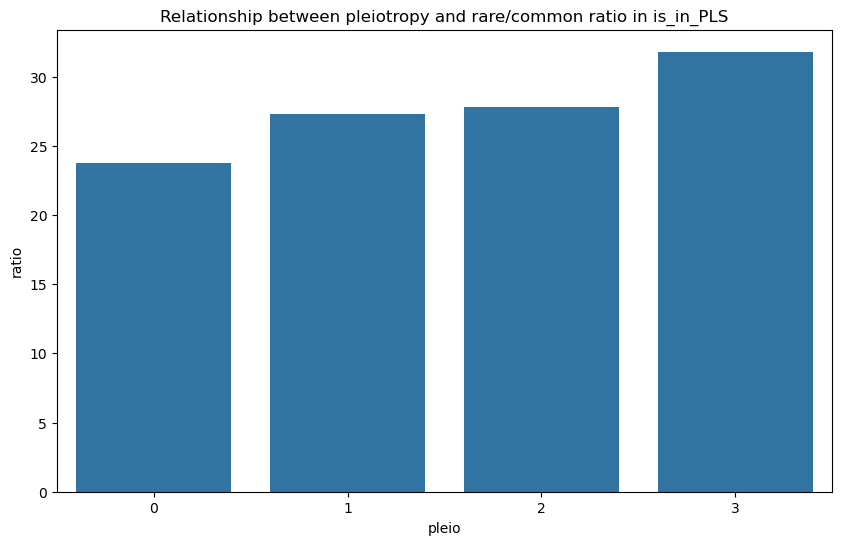

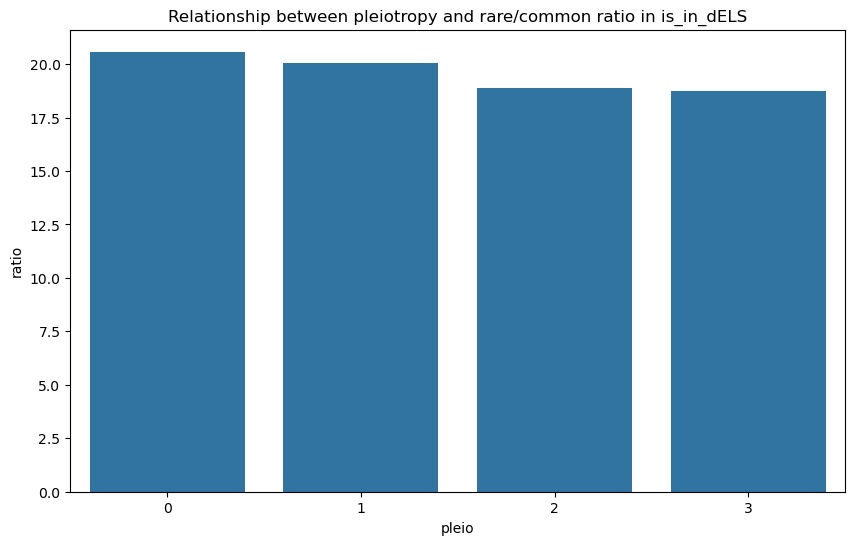

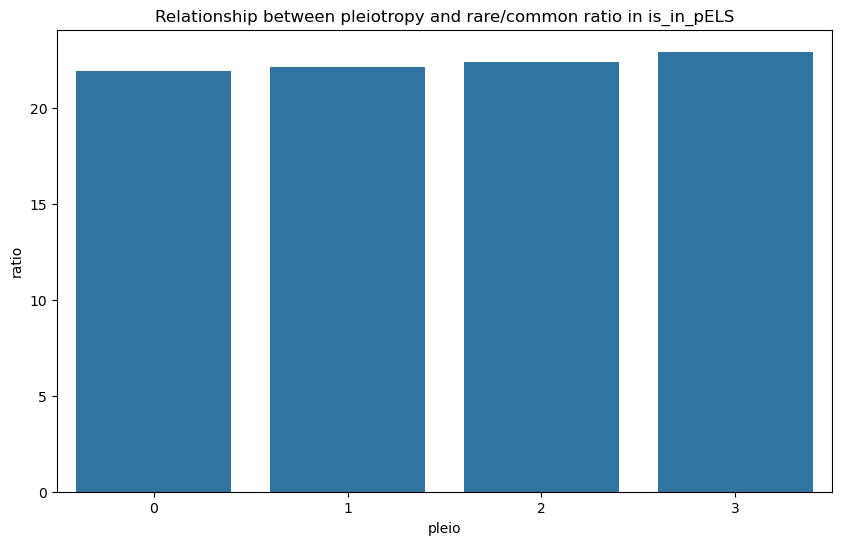

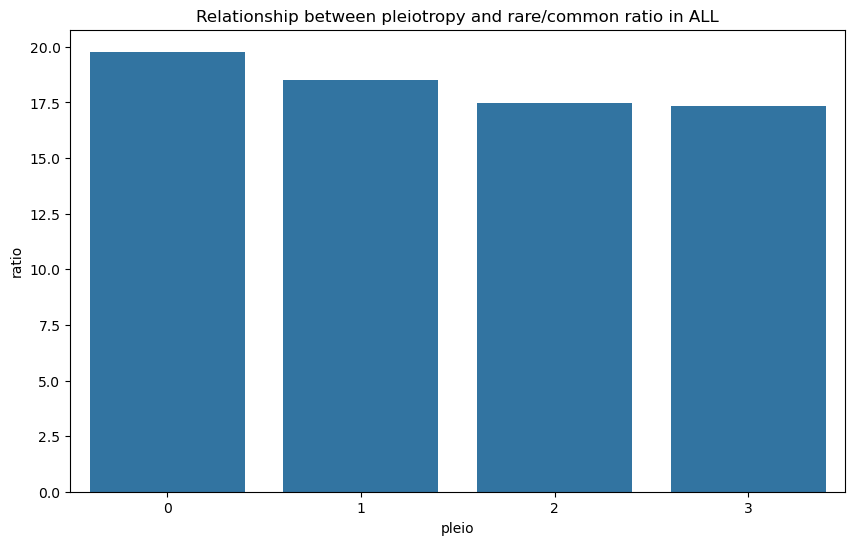

In [5]:
for var in GC.genome_regions:
    plot_rarity_pleio(rarity_pleio,genomic_region=var)

## CADD vs pleiotropy

Load data

In [6]:
cadd_pleio = pd.read_csv(glob.glob(GC.data_base_path+"CADD_pleio/*.csv")[0])

Convert multiple boolean columns to single categorical column

In [7]:
cadd_pleio['CADD_category'] = cadd_pleio.apply(GC.find_true_column, columns=GC.CADD_order, default=GC.CADD_default, axis=1)

Define a function to plot CADD vs pleiotropy

In [8]:
def plot_pleio(df, genomic_region,normalize):
    
    subset_df=None
    
    if genomic_region=="ALL":
        subset_df=df.groupby(["pleio","CADD_category"])["count"].sum().reset_index()
    else:
        subset_df = df[df[genomic_region]].copy()

    if normalize:

        # Calculate the total count for each phylop_significant category

        total_counts = subset_df.groupby('CADD_category')['count'].sum()

        # Normalize the counts by the total counts
        subset_df['normalized_count'] = subset_df.apply(lambda row: row['count'] / total_counts[row['CADD_category']], axis=1)
        value_col = 'normalized_count'
        ylabel = 'Fraction of Count'
    else:
        value_col = 'count'
        ylabel = 'Count'


    plt.figure(figsize=(10, 6))
    sns.barplot(x='CADD_category', y=value_col, hue='pleio', data=subset_df,order=GC.CADD_order)
    plt.title(f"Relationship between pleiotropy and CADD\n{'Normalized so each cadd bin sums to 1.0 ' if normalize else ''}\n({genomic_region})")
    plt.xticks(rotation=45, ha='right')
    
    plt.ylabel(ylabel)
    plt.show()

Execute it : both with & without normalization, & for all genomic regions

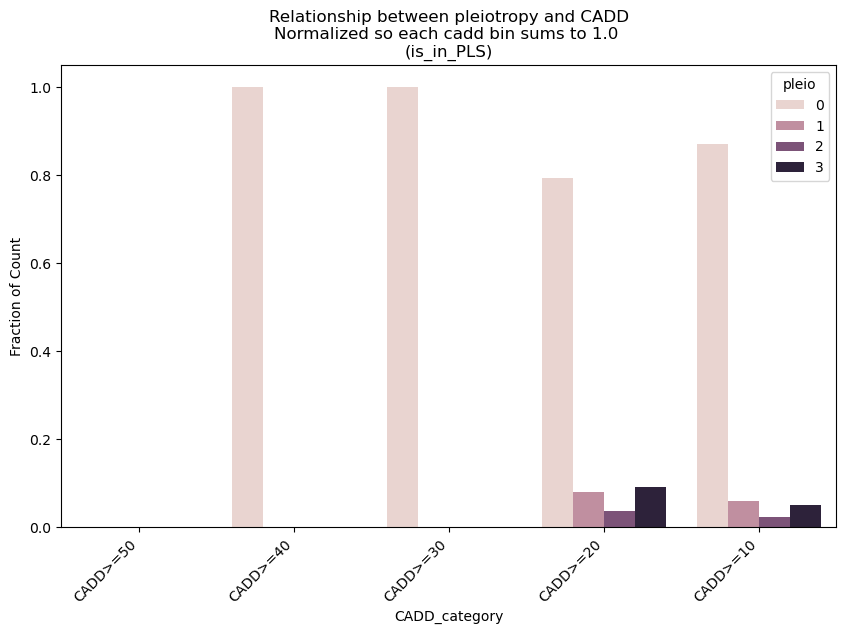

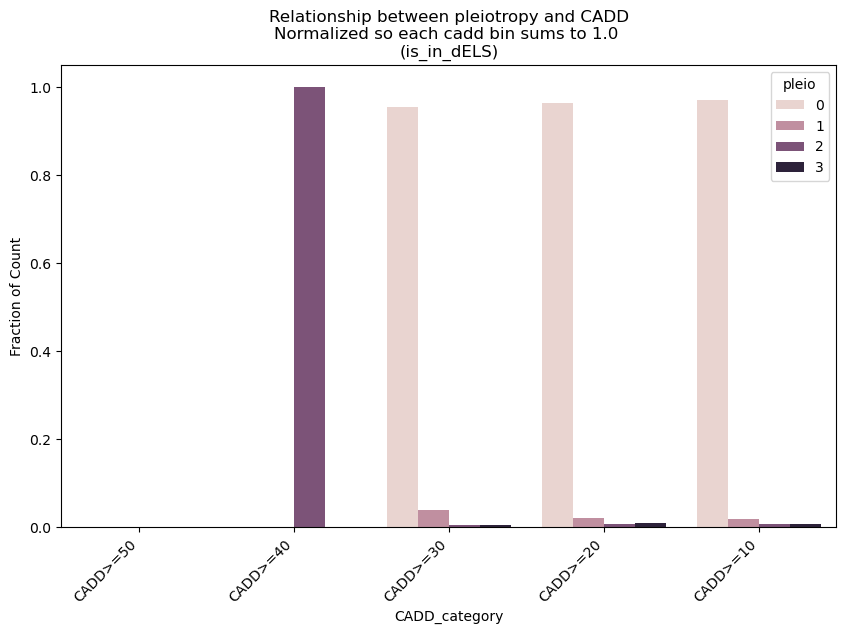

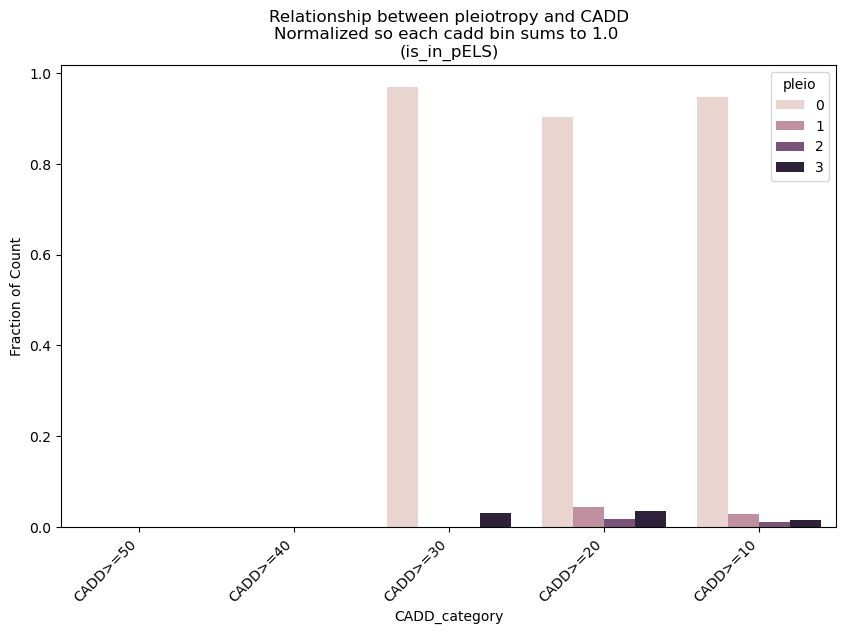

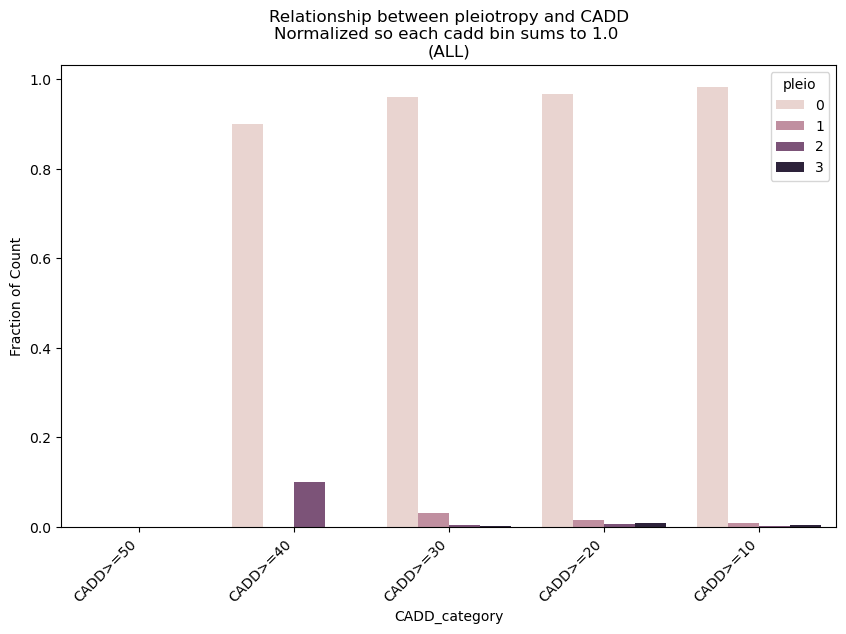

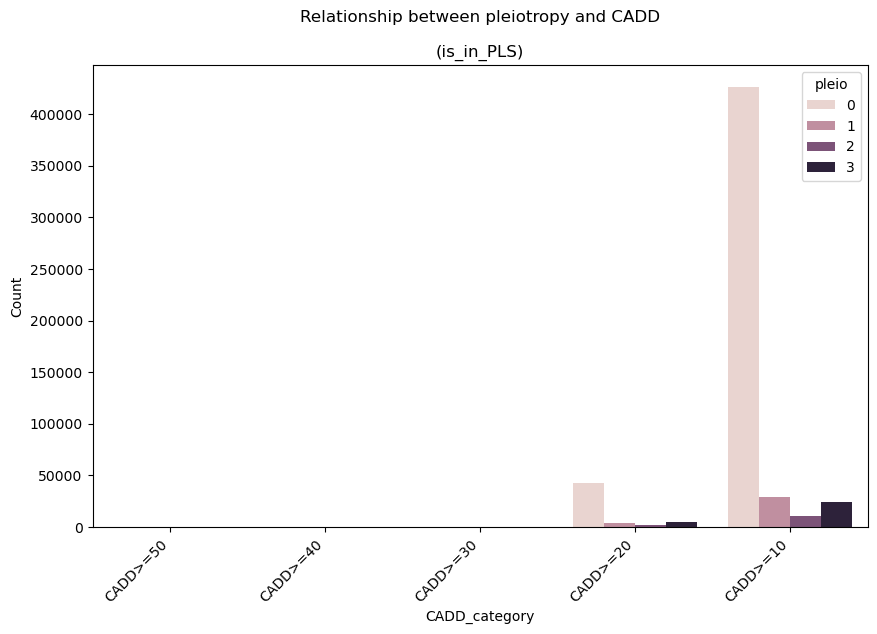

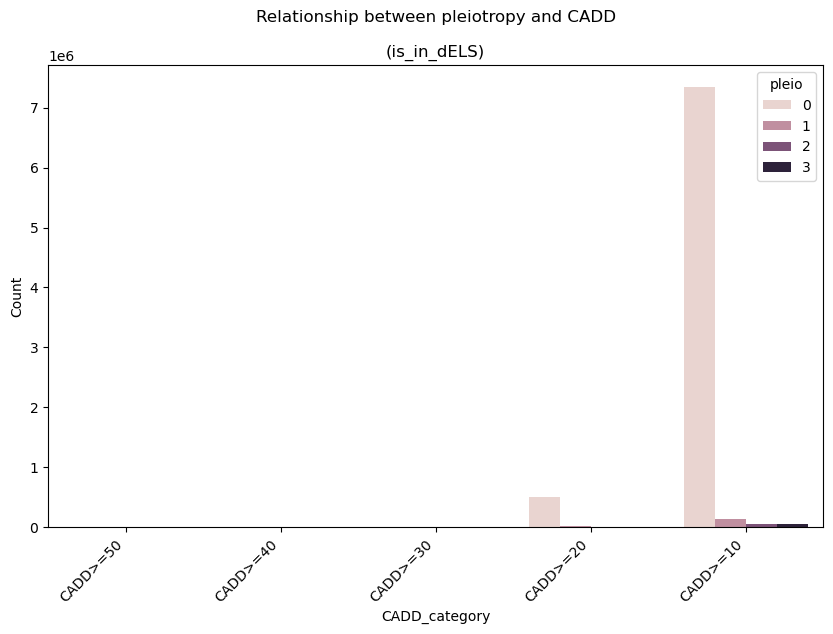

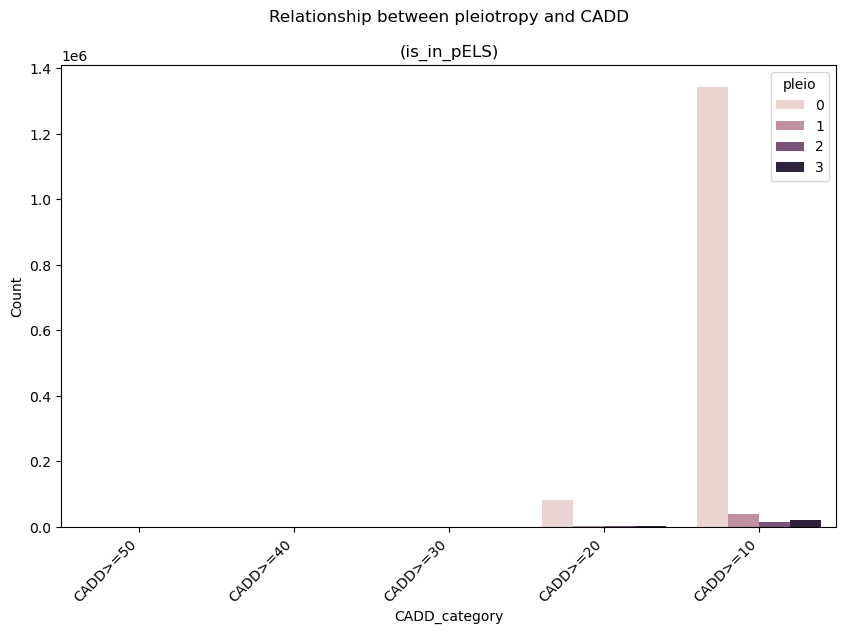

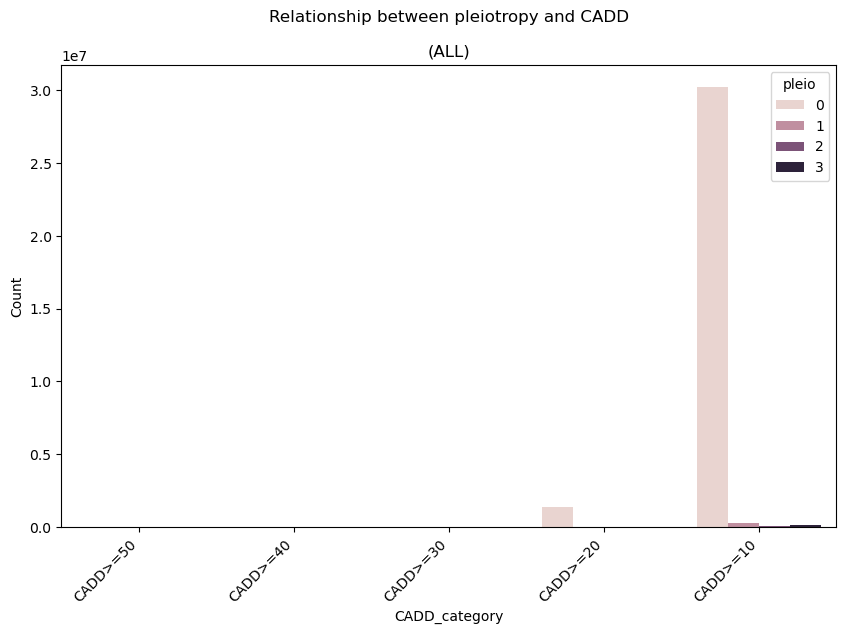

In [9]:
for norm in [True,False]:
    for var in GC.genome_regions:
        plot_pleio(df=cadd_pleio,genomic_region=var,normalize=norm)

## PhyloP vs pleiotropy

First, let's read the data. 

In [10]:
phylop_pleio = pd.read_csv(glob.glob(GC.data_base_path+"phylop_pleio/*.csv")[0])

Define a function to display fraction phylop significant as a function of pleiotropy. 

In [11]:
def plot_pleio_phylop(df,genomic_region,norm):
    #munging data
    subset_df=None
    if genomic_region=="ALL":
        subset_df=df
    else:
        subset_df = df[df[genomic_region]].copy()

    subset_df=subset_df.groupby(["pleio","phylop_significant"])["count"].sum().reset_index()

    ## Normalize or not
    if norm:
        #compute total number of variants in each pleio category...
        total_counts = subset_df.groupby(['pleio'])['count'].sum()
        #add a new column to the working dataframe, dividing each value by the total number of variants in its pleo category
        subset_df["to_graph"]=subset_df.apply(lambda row: row['count'] / total_counts[row['pleio']], axis=1)
    else:
        #we aren't normalizing, so just make the "to_graph" the count
        subset_df["to_graph"]=subset_df["count"]

    ##plotting
    plt.figure(figsize=(5, 5))
    sns.barplot(subset_df,y="to_graph",x="pleio",hue="phylop_significant")
    plt.xticks(rotation=45, ha='right')
    plt.title("PhyloP significance as a function of pleitropy\n"+genomic_region+f"\n{'normalized so each pleo bin sums to 1' if norm else ''}")
    plt.show()

Now let's call the fucntion. As above.

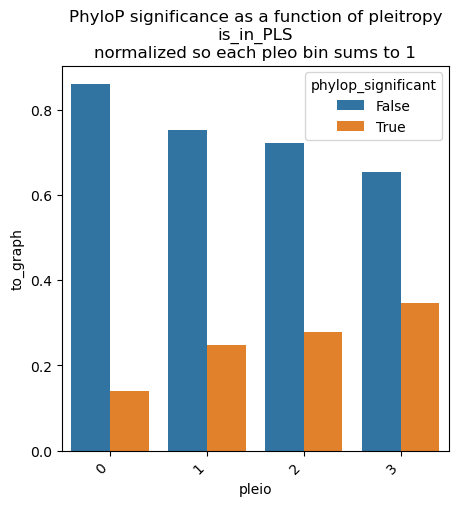

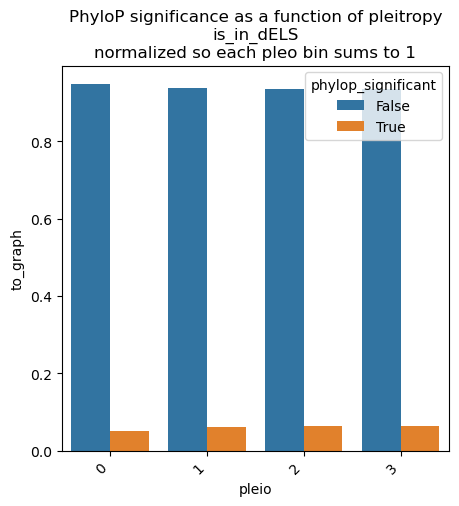

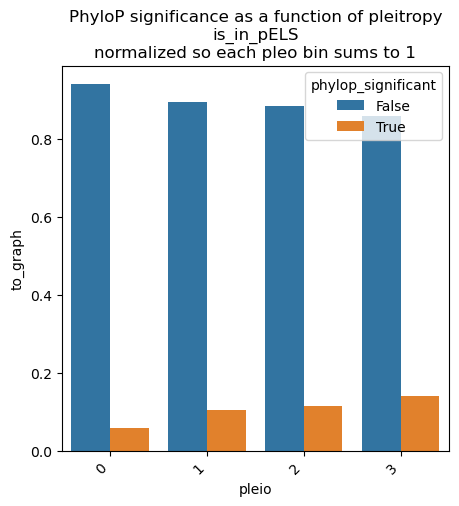

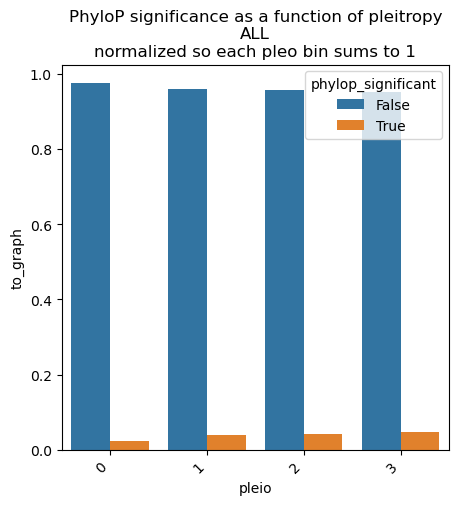

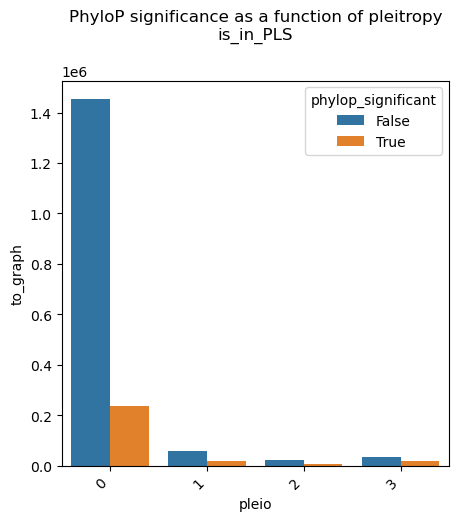

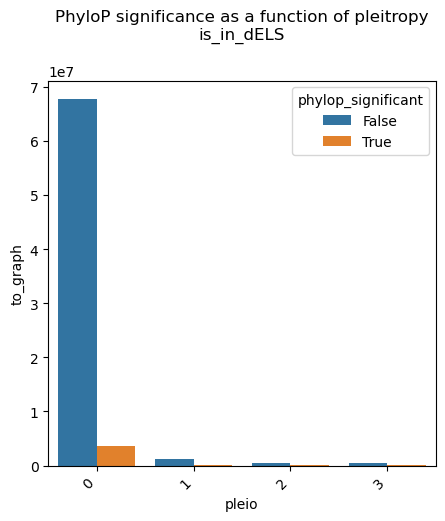

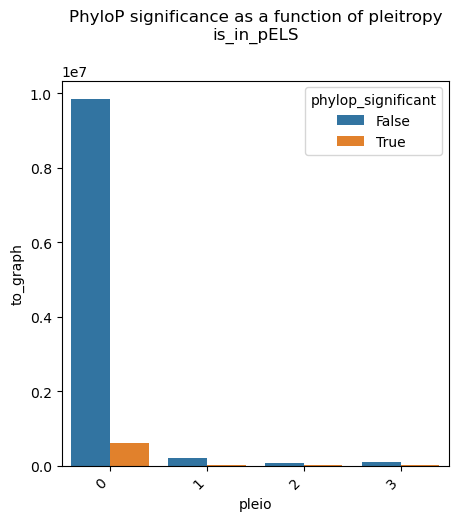

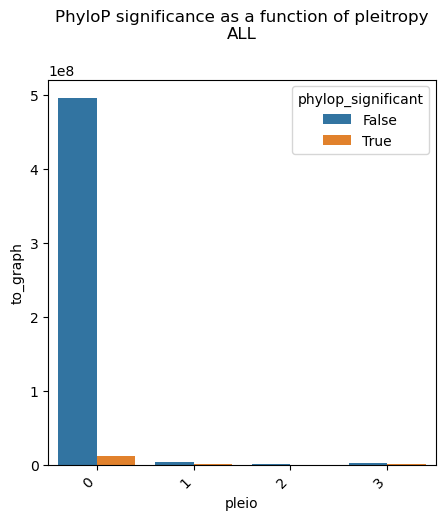

In [12]:
for norm in [True,False]:
    for var in GC.genome_regions:
        plot_pleio_phylop(df=phylop_pleio,genomic_region=var,norm=norm)